### 초기 경로 설정 (클래스 이용을 위함)

In [1]:
%cd /project/segmentation/smcho1201/segmentation_project

/project/segmentation/smcho1201/segmentation_project


In [2]:
# files and system
import os
import sys
import time
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from IPython.display import clear_output
# working with images
import cv2
import imageio
import scipy.ndimage
# import skimage.transform

import torchvision.transforms as transforms

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F


import torchsummary
from tqdm import notebook

sys.path.insert(0, '..')

# losses
from utils.metrics import iou_pytorch_eval, IoULoss, IoUBCELoss, DiceBCELoss , dice_pytorch_eval
from utils.metrics import iou_pytorch_test, dice_pytorch_test, precision_pytorch_test, recall_pytorch_test, fbeta_pytorch_test, accuracy_pytorch_test

# dataset
from utils.dataset import myDataSet

## 랜덤성을 배제한 환경 고정

In [3]:
random_seed= 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [4]:
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu") # select device for training, i.e. gpu or cpu
print(DEVICE)

cuda:1


# 1. Image augentation
> 실험할 때는 아예 augmentation도 고정시켜서 저장한 이미지를 사용해야 함.

In [5]:
_size = 224, 224
resize = transforms.Resize(_size, interpolation=0)

# set your transforms 
train_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                           transforms.RandomRotation(180),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(_size, padding = 10), # needed after rotation (with original size)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                       ])

/home/smcho1201/.conda/envs/pytorch/lib/python3.9/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


# 2. 데이터셋 클래스 생성
> 해당 클래스는 이용하려는 이미지와 라벨의 모든 경로(/data/segmentation/...)의 리스트를 인자로 받는다.   

In [6]:
train_images = glob.glob('/data/segmentation/breast-cancer/trainset_benign/images/*')
train_labels = glob.glob('/data/segmentation/breast-cancer/trainset_benign/labels/*')
train_images = [img for img in train_images if img.find('jpg')!= -1] # super pixels 이미지 제외

valid_images = glob.glob('/data/segmentation/breast-cancer/validationset_benign/images/*')
valid_labels = glob.glob('/data/segmentation/breast-cancer/validationset_benign/labels/*')
valid_images = [img for img in valid_images if img.find('jpg')!= -1] # super pixels 이미지 제외

train_images = sorted(train_images)
train_labels = sorted(train_labels)

valid_images = sorted(valid_images)
valid_labels = sorted(valid_labels)

# 데이터셋 클래스 적용
custom_dataset_train = myDataSet(train_images, train_labels, transforms=test_transforms)
print("My custom training-dataset has {} elements".format(len(custom_dataset_train)))

custom_dataset_val = myDataSet(valid_images, valid_labels, transforms=test_transforms)
print("My custom valing-dataset has {} elements".format(len(custom_dataset_val)))

My custom training-dataset has 261 elements
My custom valing-dataset has 88 elements


### dataset class check
> RGB 채널 평균 값이라 색 바뀜

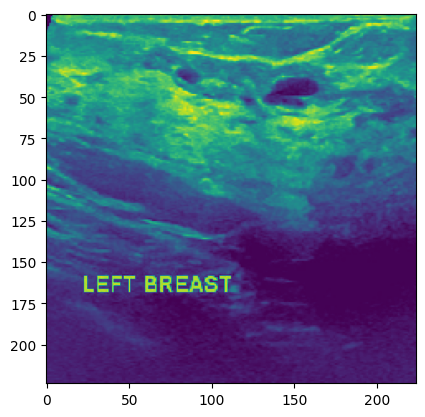

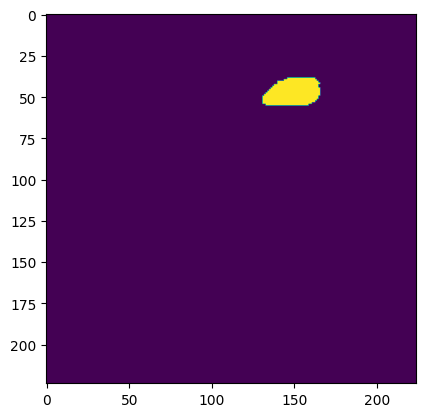

3픽셀의 평균값이라 색깔이 변경됨.


In [7]:
# Show example images.
image_number = 23
img, mask = custom_dataset_train.__getitem__(image_number)

# image
plt.figure()
plt.imshow(img.mean(0)) # 3 channels, take mean

# mask
plt.figure()
plt.imshow(mask[0, :, :]) # 1 channel, take it

plt.show()
print('3픽셀의 평균값이라 색깔이 변경됨.')

# 3. 모델 클래스 생성

In [8]:
# Begin training
from models.DeepLab_V3_p.model import DeepLab as DeepLab_V3_p
model = DeepLab_V3_p(backbone = 'resnet', num_classes = 1)   # backbone : 선택 (resnet, xception, mobilenet)
model = model.to(DEVICE) # load model to DEVICE

# 4. 하이퍼 파라미터 세팅 & 데이터 로더 생성

In [9]:
# Define variables for the training
epochs = 100
patience = 20
BATCH_SIZE = 8

dataloader_train = torch.utils.data.DataLoader(custom_dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(custom_dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [10]:
# Define optimiser and criterion for the training. You can try different ones to see which works best for your data and task
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-8)

criterion = DiceBCELoss()
model_name = 'DeepLab_V3+'
data_name = 'benign'

# 5. Training

/home/smcho1201/.conda/envs/pytorch/lib/python3.9/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 Epoch: 1 of 100, Iter.: 33 of 33, Train Loss: 1.266940, IoU: 0.190129, Dice: 0.290129
 Epoch: 1 of 100, Iter.: 33 of 33, Valid Loss: 1.402377, IoU: 0.211902, Dice: 0.326038

시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.


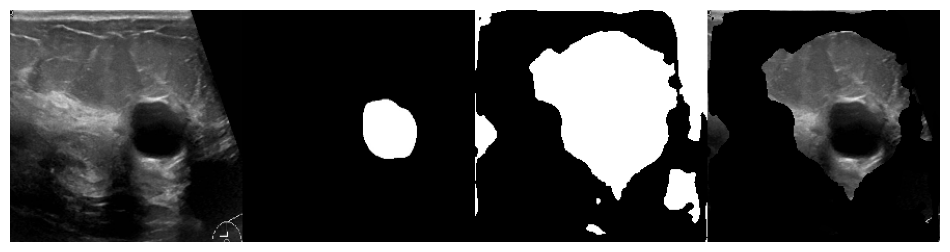

 Epoch: 2 of 100, Iter.: 33 of 33, Train Loss: 0.830252, IoU: 0.470924, Dice: 0.586544
 Epoch: 2 of 100, Iter.: 33 of 33, Valid Loss: 1.204203, IoU: 0.364793, Dice: 0.488365


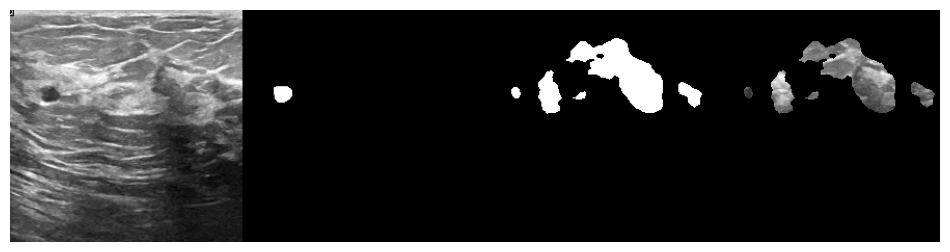

 Epoch: 3 of 100, Iter.: 33 of 33, Train Loss: 0.577689, IoU: 0.563666, Dice: 0.673963
 Epoch: 3 of 100, Iter.: 33 of 33, Valid Loss: 0.912339, IoU: 0.474147, Dice: 0.589530


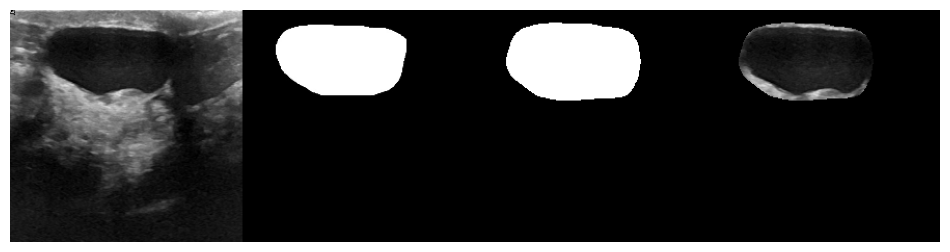

 Epoch: 4 of 100, Iter.: 33 of 33, Train Loss: 0.408513, IoU: 0.632168, Dice: 0.737154
 Epoch: 4 of 100, Iter.: 33 of 33, Valid Loss: 0.490172, IoU: 0.588111, Dice: 0.697296


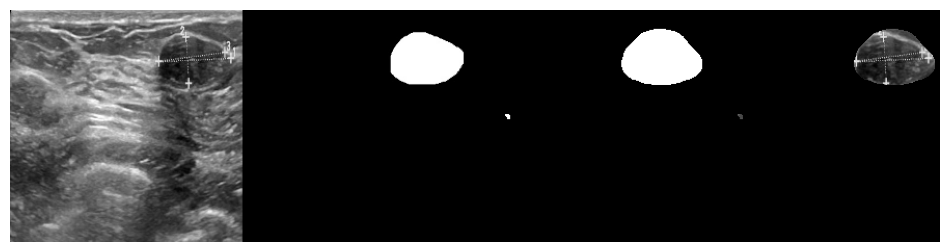

 Epoch: 5 of 100, Iter.: 33 of 33, Train Loss: 0.310719, IoU: 0.682454, Dice: 0.782466
 Epoch: 5 of 100, Iter.: 33 of 33, Valid Loss: 0.398395, IoU: 0.601805, Dice: 0.698123


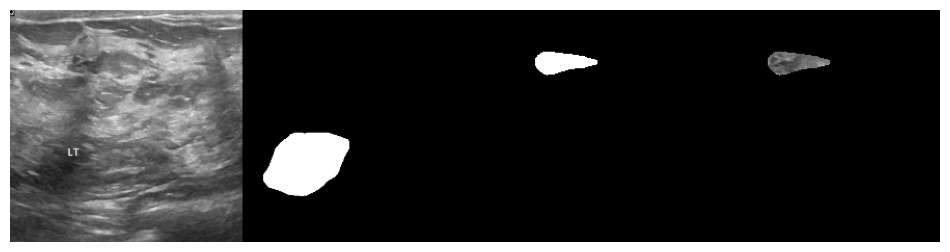

 Epoch: 6 of 100, Iter.: 33 of 33, Train Loss: 0.290525, IoU: 0.736121, Dice: 0.829691
 Epoch: 6 of 100, Iter.: 33 of 33, Valid Loss: 0.382371, IoU: 0.635580, Dice: 0.729811


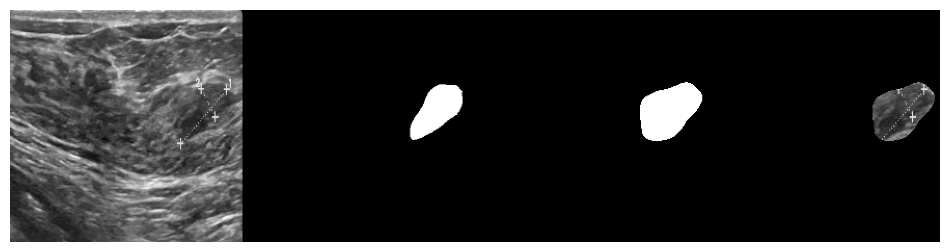

 Epoch: 7 of 100, Iter.: 33 of 33, Train Loss: 0.219415, IoU: 0.755719, Dice: 0.845753
 Epoch: 7 of 100, Iter.: 33 of 33, Valid Loss: 0.349113, IoU: 0.636359, Dice: 0.732223


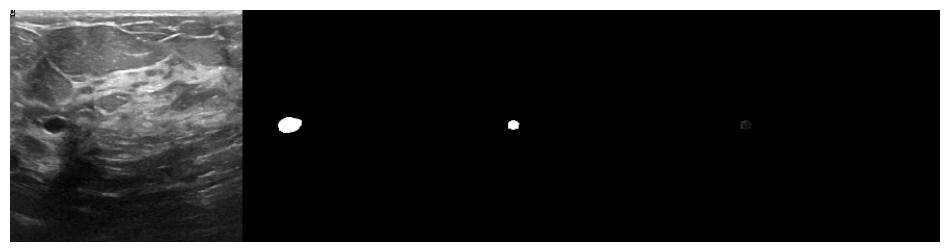

 Epoch: 8 of 100, Iter.: 33 of 33, Train Loss: 0.183669, IoU: 0.776220, Dice: 0.860972
 Epoch: 8 of 100, Iter.: 33 of 33, Valid Loss: 0.331043, IoU: 0.626123, Dice: 0.719894


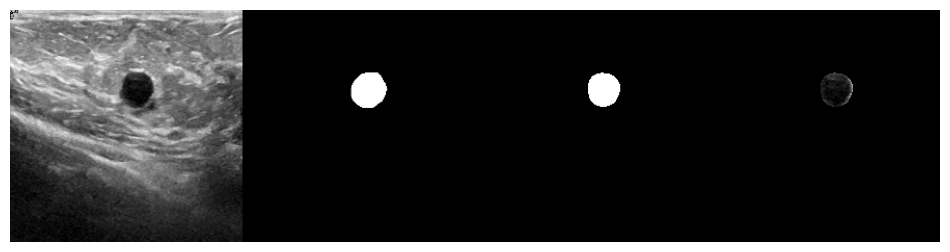

 Epoch: 9 of 100, Iter.: 33 of 33, Train Loss: 0.144760, IoU: 0.815008, Dice: 0.887937
 Epoch: 9 of 100, Iter.: 33 of 33, Valid Loss: 0.316175, IoU: 0.662090, Dice: 0.759372


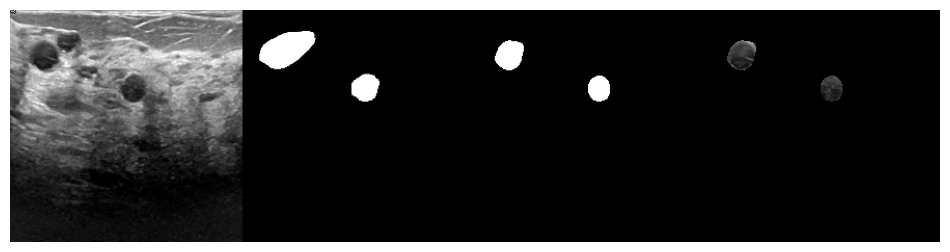

 Epoch: 10 of 100, Iter.: 33 of 33, Train Loss: 0.134488, IoU: 0.819612, Dice: 0.889591
 Epoch: 10 of 100, Iter.: 33 of 33, Valid Loss: 0.296686, IoU: 0.682703, Dice: 0.776445


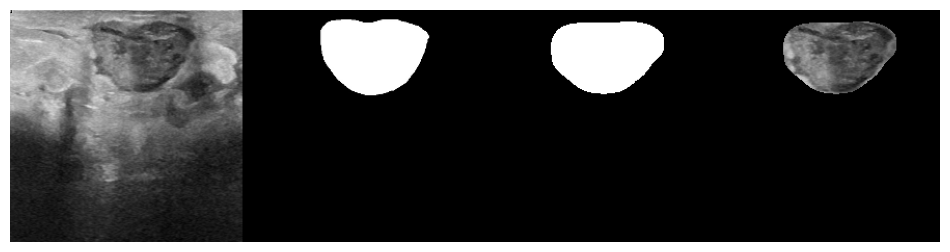

 Epoch: 11 of 100, Iter.: 33 of 33, Train Loss: 0.152686, IoU: 0.823902, Dice: 0.892448
 Epoch: 11 of 100, Iter.: 33 of 33, Valid Loss: 0.343115, IoU: 0.646563, Dice: 0.740034


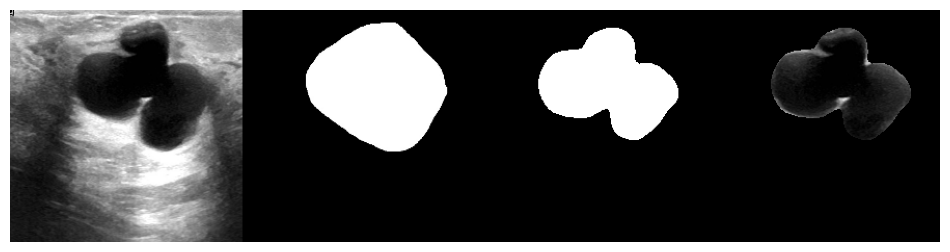

 Epoch: 12 of 100, Iter.: 33 of 33, Train Loss: 0.132970, IoU: 0.820068, Dice: 0.889405
 Epoch: 12 of 100, Iter.: 33 of 33, Valid Loss: 0.316767, IoU: 0.666732, Dice: 0.762562


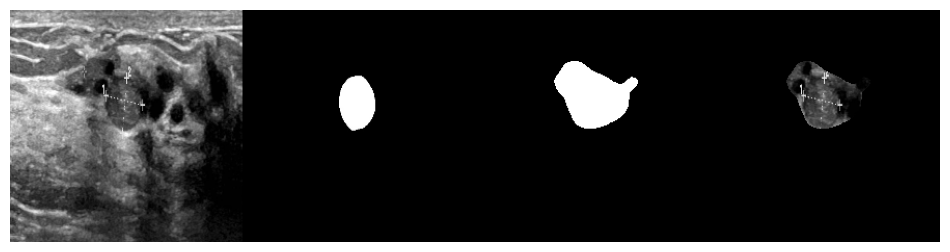

 Epoch: 13 of 100, Iter.: 33 of 33, Train Loss: 0.114310, IoU: 0.839679, Dice: 0.905430
 Epoch: 13 of 100, Iter.: 33 of 33, Valid Loss: 0.337424, IoU: 0.672800, Dice: 0.766744


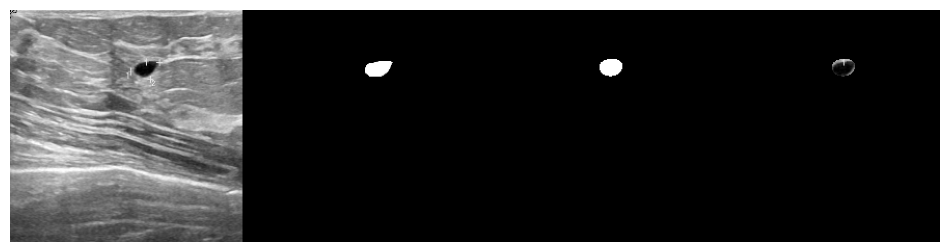

 Epoch: 14 of 100, Iter.: 33 of 33, Train Loss: 0.100116, IoU: 0.863457, Dice: 0.922808
 Epoch: 14 of 100, Iter.: 33 of 33, Valid Loss: 0.317354, IoU: 0.672171, Dice: 0.765696


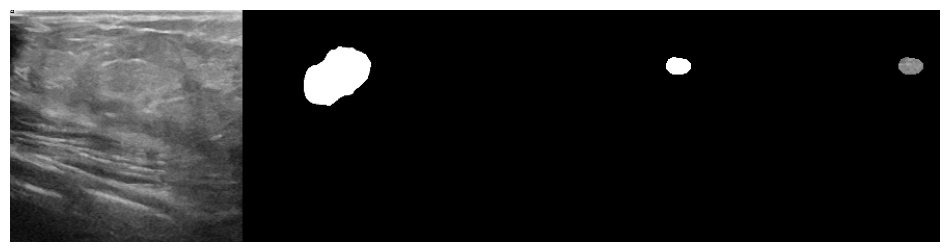

 Epoch: 15 of 100, Iter.: 33 of 33, Train Loss: 0.096355, IoU: 0.867138, Dice: 0.925671
 Epoch: 15 of 100, Iter.: 33 of 33, Valid Loss: 0.337175, IoU: 0.678064, Dice: 0.772107


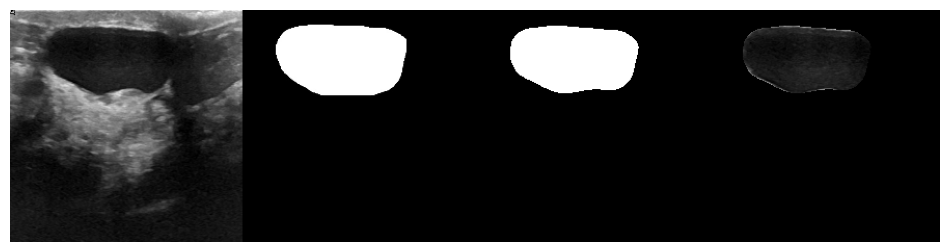

 Epoch: 16 of 100, Iter.: 33 of 33, Train Loss: 0.094373, IoU: 0.860645, Dice: 0.922323
 Epoch: 16 of 100, Iter.: 33 of 33, Valid Loss: 0.307328, IoU: 0.674271, Dice: 0.770149


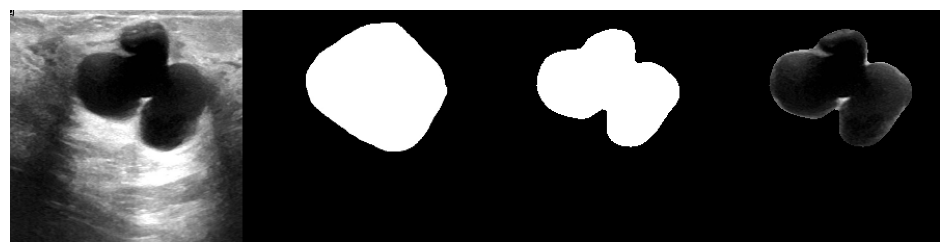

 Epoch: 17 of 100, Iter.: 33 of 33, Train Loss: 0.091397, IoU: 0.858305, Dice: 0.918045
 Epoch: 17 of 100, Iter.: 33 of 33, Valid Loss: 0.318289, IoU: 0.681865, Dice: 0.773823


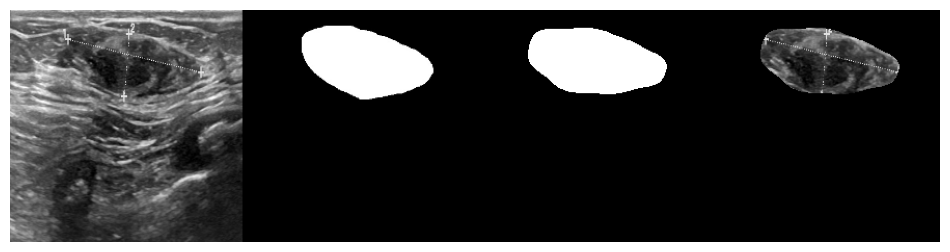

 Epoch: 18 of 100, Iter.: 33 of 33, Train Loss: 0.078820, IoU: 0.875637, Dice: 0.929618
 Epoch: 18 of 100, Iter.: 33 of 33, Valid Loss: 0.331293, IoU: 0.683186, Dice: 0.776153


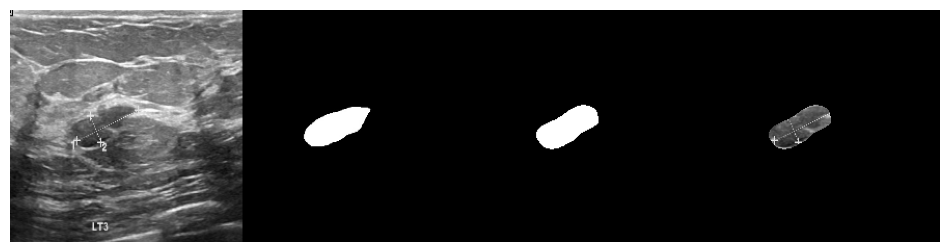

 Epoch: 19 of 100, Iter.: 33 of 33, Train Loss: 0.074382, IoU: 0.895534, Dice: 0.943591
 Epoch: 19 of 100, Iter.: 33 of 33, Valid Loss: 0.312158, IoU: 0.681035, Dice: 0.772746


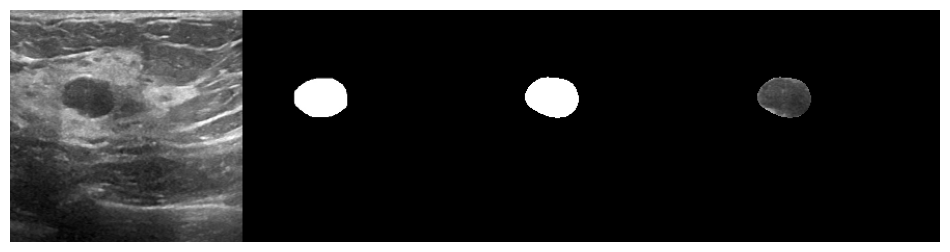

 Epoch: 20 of 100, Iter.: 33 of 33, Train Loss: 0.067922, IoU: 0.899409, Dice: 0.945782
 Epoch: 20 of 100, Iter.: 33 of 33, Valid Loss: 0.329306, IoU: 0.676616, Dice: 0.767954


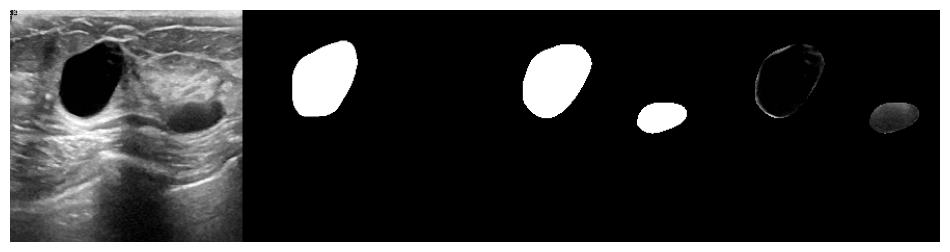

 Epoch: 21 of 100, Iter.: 33 of 33, Train Loss: 0.068054, IoU: 0.903073, Dice: 0.947912
 Epoch: 21 of 100, Iter.: 33 of 33, Valid Loss: 0.321755, IoU: 0.684553, Dice: 0.776158


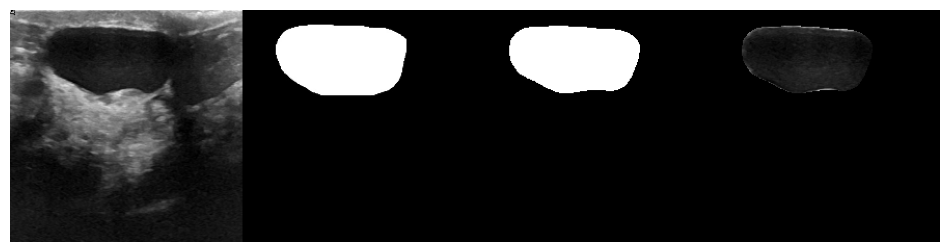

 Epoch: 22 of 100, Iter.: 33 of 33, Train Loss: 0.063774, IoU: 0.899273, Dice: 0.944417
 Epoch: 22 of 100, Iter.: 33 of 33, Valid Loss: 0.318080, IoU: 0.680377, Dice: 0.773015


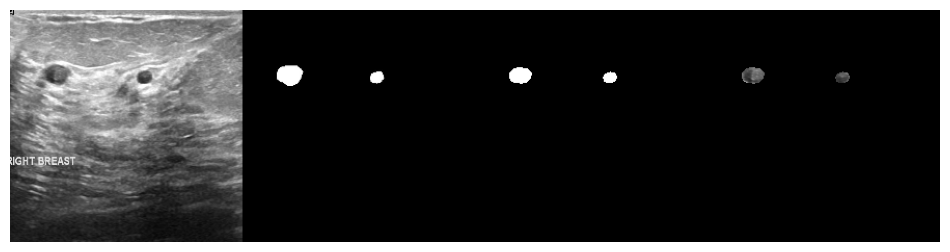

 Epoch: 23 of 100, Iter.: 33 of 33, Train Loss: 0.062946, IoU: 0.901814, Dice: 0.946939
 Epoch: 23 of 100, Iter.: 33 of 33, Valid Loss: 0.325180, IoU: 0.676804, Dice: 0.768920


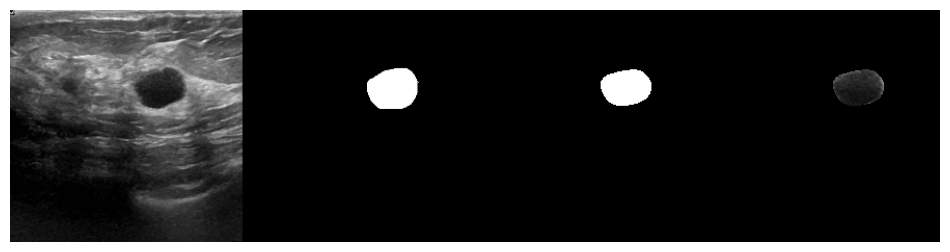

 Epoch: 24 of 100, Iter.: 33 of 33, Train Loss: 0.060033, IoU: 0.904006, Dice: 0.947975
 Epoch: 24 of 100, Iter.: 33 of 33, Valid Loss: 0.319463, IoU: 0.686716, Dice: 0.777848


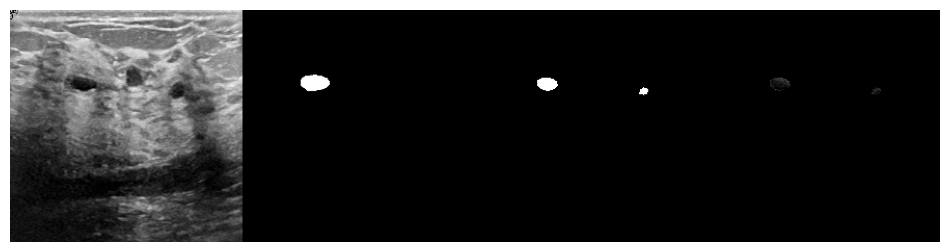

 Epoch: 25 of 100, Iter.: 33 of 33, Train Loss: 0.056309, IoU: 0.910224, Dice: 0.952139
 Epoch: 25 of 100, Iter.: 33 of 33, Valid Loss: 0.335190, IoU: 0.673514, Dice: 0.767596


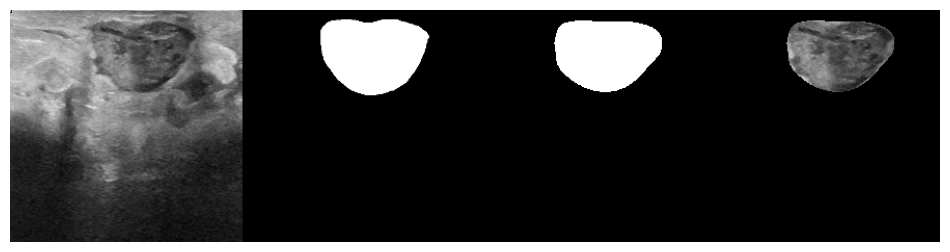

 Epoch: 26 of 100, Iter.: 33 of 33, Train Loss: 0.057379, IoU: 0.907724, Dice: 0.950477
 Epoch: 26 of 100, Iter.: 33 of 33, Valid Loss: 0.313081, IoU: 0.688044, Dice: 0.779894


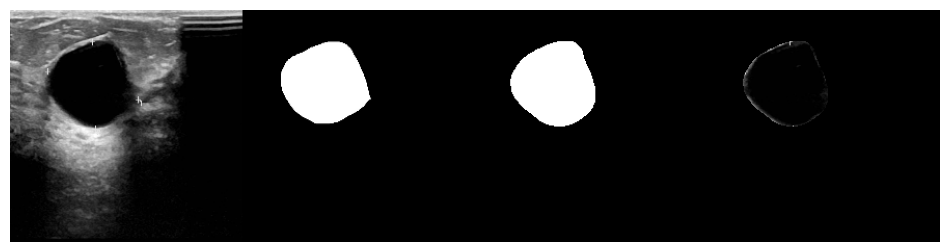

 Epoch: 27 of 100, Iter.: 33 of 33, Train Loss: 0.054082, IoU: 0.911824, Dice: 0.952350
 Epoch: 27 of 100, Iter.: 33 of 33, Valid Loss: 0.315522, IoU: 0.694292, Dice: 0.784149


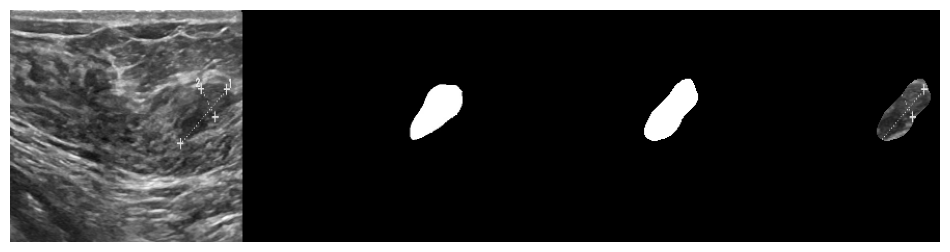

 Epoch: 28 of 100, Iter.: 33 of 33, Train Loss: 0.052788, IoU: 0.914201, Dice: 0.954360
 Epoch: 28 of 100, Iter.: 33 of 33, Valid Loss: 0.328024, IoU: 0.688249, Dice: 0.778984


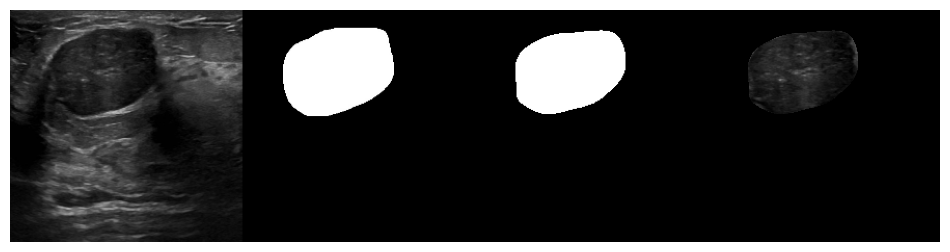

 Epoch: 29 of 100, Iter.: 33 of 33, Train Loss: 0.054244, IoU: 0.916200, Dice: 0.955513
 Epoch: 29 of 100, Iter.: 33 of 33, Valid Loss: 0.330110, IoU: 0.686709, Dice: 0.777534


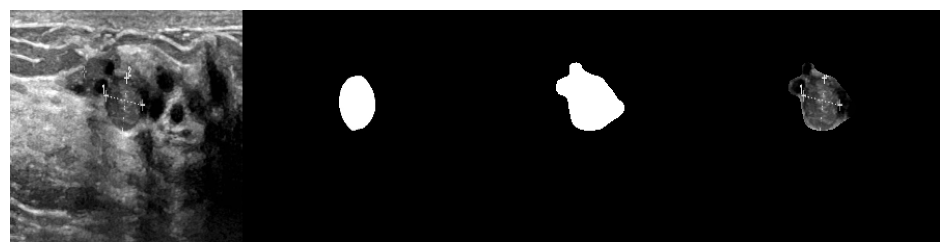

 Epoch: 30 of 100, Iter.: 33 of 33, Train Loss: 0.052542, IoU: 0.914445, Dice: 0.954471
 Epoch: 30 of 100, Iter.: 33 of 33, Valid Loss: 0.332304, IoU: 0.693461, Dice: 0.783842


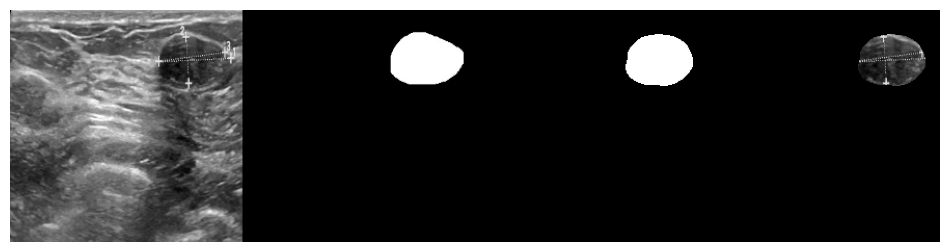

 Epoch: 31 of 100, Iter.: 33 of 33, Train Loss: 0.071421, IoU: 0.893505, Dice: 0.940976
 Epoch: 31 of 100, Iter.: 33 of 33, Valid Loss: 0.350357, IoU: 0.667920, Dice: 0.760882


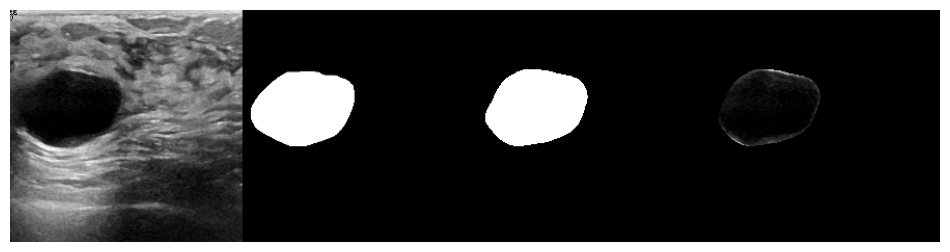

 Epoch: 32 of 100, Iter.: 33 of 33, Train Loss: 0.101108, IoU: 0.860761, Dice: 0.919721
 Epoch: 32 of 100, Iter.: 33 of 33, Valid Loss: 0.333000, IoU: 0.685777, Dice: 0.773730


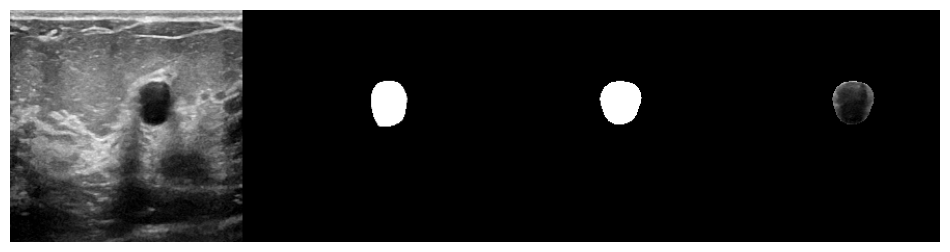

 Epoch: 33 of 100, Iter.: 33 of 33, Train Loss: 0.095606, IoU: 0.862832, Dice: 0.919884
 Epoch: 33 of 100, Iter.: 33 of 33, Valid Loss: 0.331154, IoU: 0.687500, Dice: 0.781493


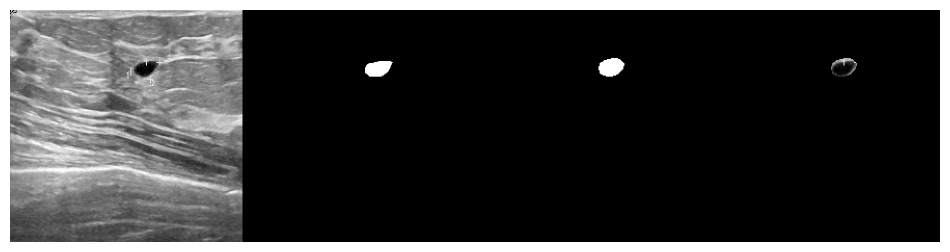

 Epoch: 34 of 100, Iter.: 33 of 33, Train Loss: 0.079814, IoU: 0.875914, Dice: 0.931099
 Epoch: 34 of 100, Iter.: 33 of 33, Valid Loss: 0.290716, IoU: 0.709752, Dice: 0.797864


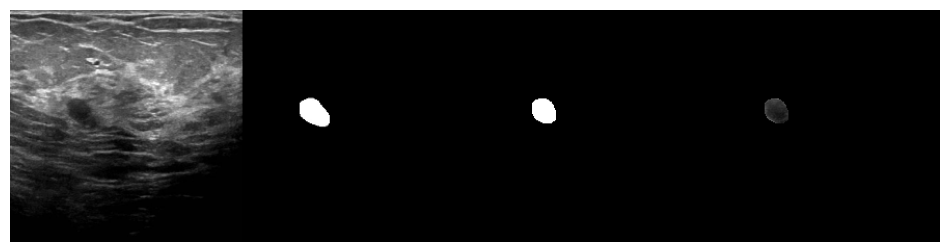

 Epoch: 35 of 100, Iter.: 33 of 33, Train Loss: 0.070876, IoU: 0.888307, Dice: 0.939219
 Epoch: 35 of 100, Iter.: 33 of 33, Valid Loss: 0.324859, IoU: 0.695460, Dice: 0.781244


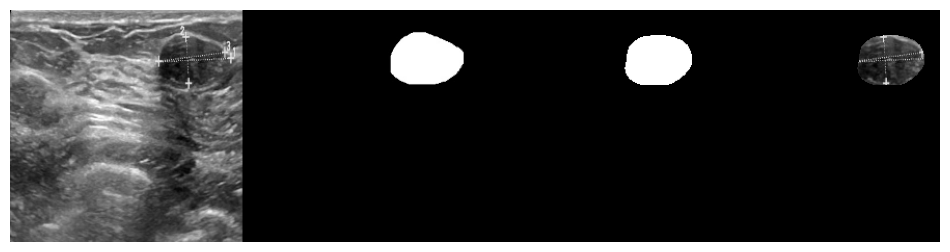

 Epoch: 36 of 100, Iter.: 33 of 33, Train Loss: 0.063001, IoU: 0.899439, Dice: 0.945752
 Epoch: 36 of 100, Iter.: 33 of 33, Valid Loss: 0.320236, IoU: 0.700462, Dice: 0.787261


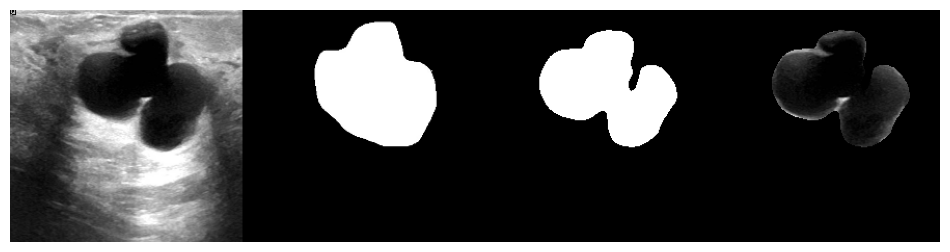

 Epoch: 37 of 100, Iter.: 33 of 33, Train Loss: 0.054517, IoU: 0.908059, Dice: 0.950578
 Epoch: 37 of 100, Iter.: 33 of 33, Valid Loss: 0.309404, IoU: 0.710328, Dice: 0.795380


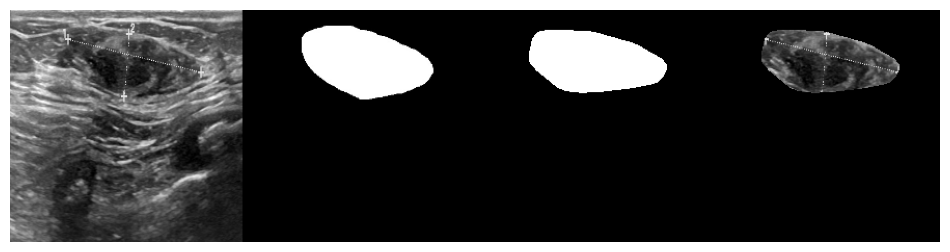

 Epoch: 38 of 100, Iter.: 33 of 33, Train Loss: 0.051140, IoU: 0.911214, Dice: 0.952356
 Epoch: 38 of 100, Iter.: 33 of 33, Valid Loss: 0.316488, IoU: 0.708912, Dice: 0.793821


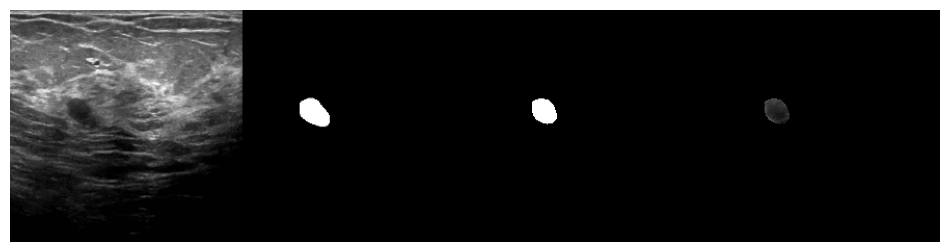

 Epoch: 39 of 100, Iter.: 33 of 33, Train Loss: 0.049361, IoU: 0.919386, Dice: 0.956884
 Epoch: 39 of 100, Iter.: 33 of 33, Valid Loss: 0.320365, IoU: 0.705429, Dice: 0.790719


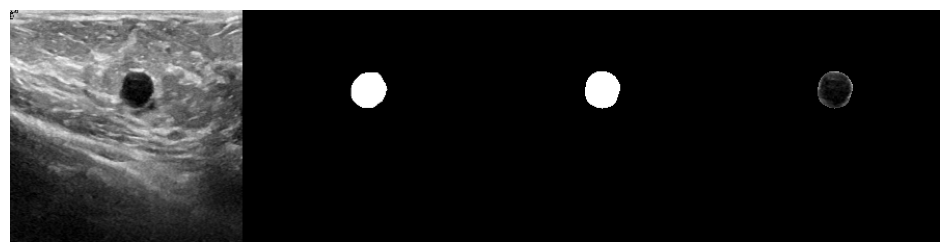

 Epoch: 40 of 100, Iter.: 33 of 33, Train Loss: 0.047282, IoU: 0.921237, Dice: 0.958323
 Epoch: 40 of 100, Iter.: 33 of 33, Valid Loss: 0.330628, IoU: 0.707401, Dice: 0.791590


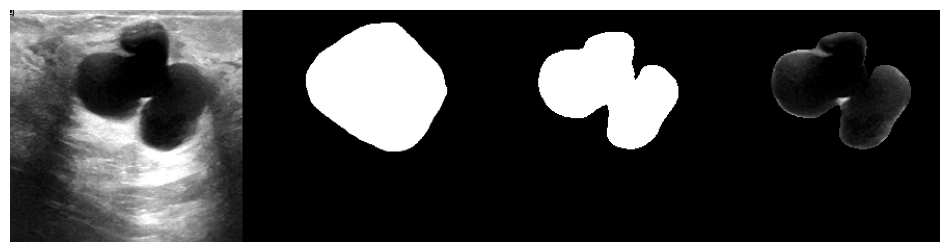

 Epoch: 41 of 100, Iter.: 33 of 33, Train Loss: 0.043126, IoU: 0.925552, Dice: 0.960717
 Epoch: 41 of 100, Iter.: 33 of 33, Valid Loss: 0.329025, IoU: 0.706564, Dice: 0.791778


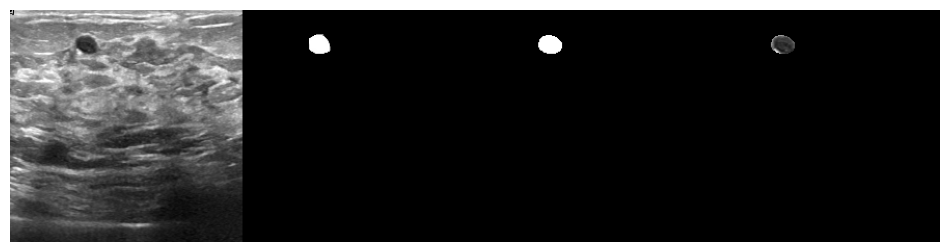

 Epoch: 42 of 100, Iter.: 33 of 33, Train Loss: 0.041916, IoU: 0.928607, Dice: 0.962387
 Epoch: 42 of 100, Iter.: 33 of 33, Valid Loss: 0.323979, IoU: 0.702875, Dice: 0.788320


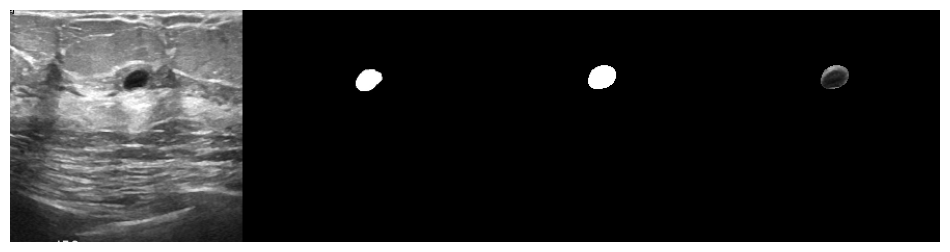

 Epoch: 43 of 100, Iter.: 33 of 33, Train Loss: 0.041496, IoU: 0.923994, Dice: 0.959750
 Epoch: 43 of 100, Iter.: 33 of 33, Valid Loss: 0.335830, IoU: 0.702810, Dice: 0.787264


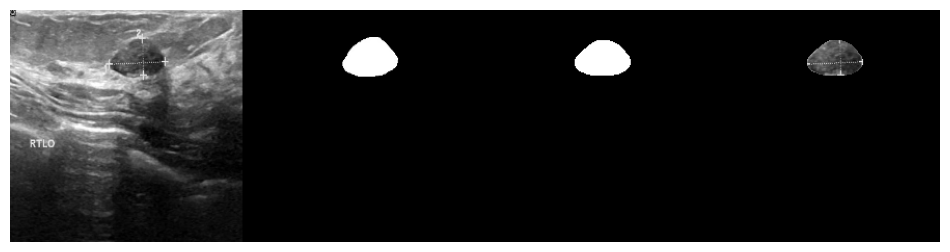

 Epoch: 44 of 100, Iter.: 33 of 33, Train Loss: 0.040745, IoU: 0.929158, Dice: 0.962777
 Epoch: 44 of 100, Iter.: 33 of 33, Valid Loss: 0.333427, IoU: 0.701311, Dice: 0.787513


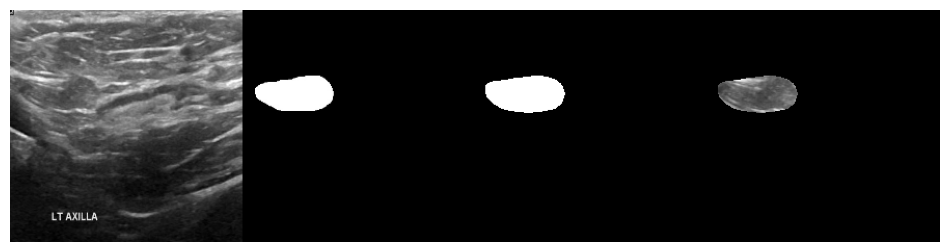

 Epoch: 45 of 100, Iter.: 33 of 33, Train Loss: 0.041110, IoU: 0.932405, Dice: 0.964554
 Epoch: 45 of 100, Iter.: 33 of 33, Valid Loss: 0.332846, IoU: 0.709427, Dice: 0.793330


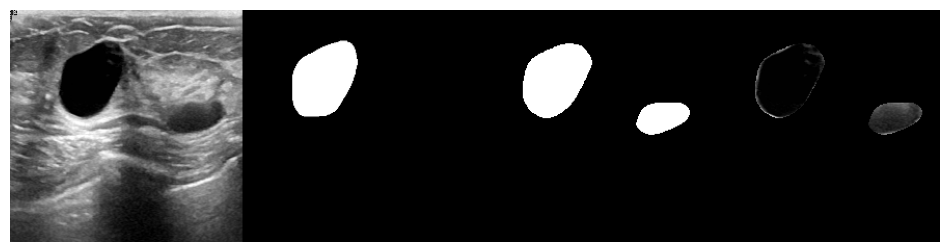

 Epoch: 46 of 100, Iter.: 33 of 33, Train Loss: 0.041698, IoU: 0.922112, Dice: 0.958577
 Epoch: 46 of 100, Iter.: 33 of 33, Valid Loss: 0.325431, IoU: 0.703813, Dice: 0.788781


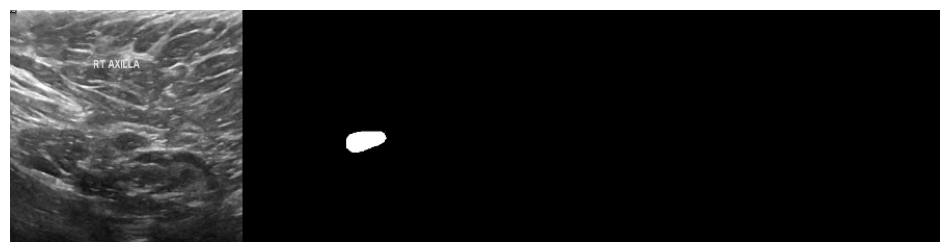

 Epoch: 47 of 100, Iter.: 33 of 33, Train Loss: 0.039639, IoU: 0.927013, Dice: 0.961424
 Epoch: 47 of 100, Iter.: 33 of 33, Valid Loss: 0.331732, IoU: 0.706965, Dice: 0.791402


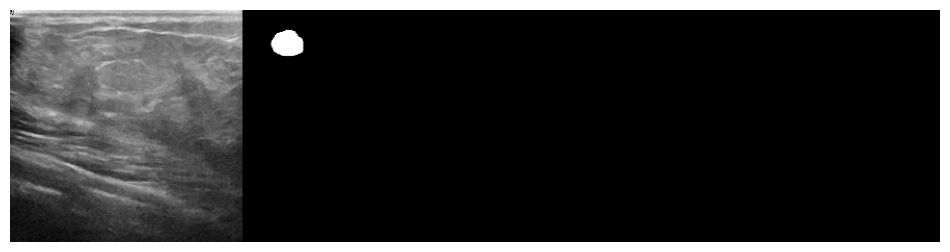

 Epoch: 48 of 100, Iter.: 33 of 33, Train Loss: 0.039078, IoU: 0.931367, Dice: 0.963964
 Epoch: 48 of 100, Iter.: 33 of 33, Valid Loss: 0.342845, IoU: 0.707062, Dice: 0.790405


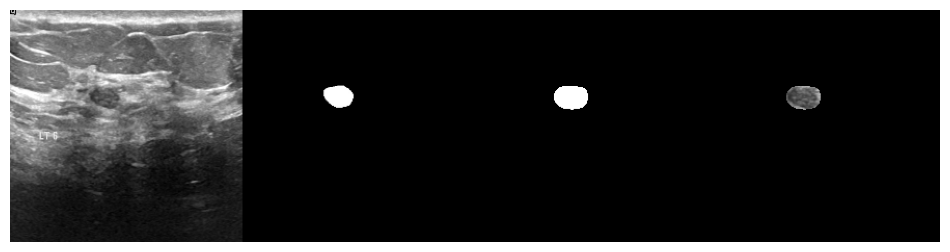

 Epoch: 49 of 100, Iter.: 33 of 33, Train Loss: 0.037616, IoU: 0.932186, Dice: 0.964363
 Epoch: 49 of 100, Iter.: 33 of 33, Valid Loss: 0.367554, IoU: 0.705345, Dice: 0.788621


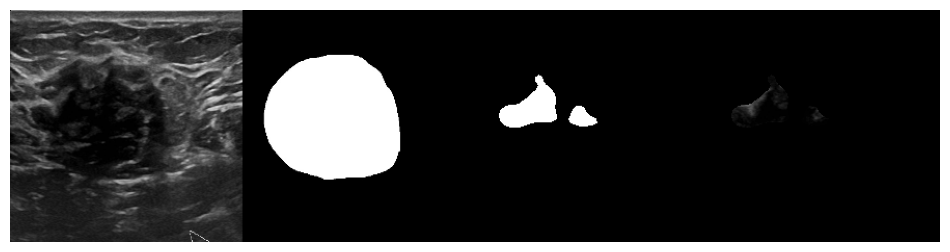

 Epoch: 50 of 100, Iter.: 33 of 33, Train Loss: 0.036985, IoU: 0.933531, Dice: 0.965030
 Epoch: 50 of 100, Iter.: 33 of 33, Valid Loss: 0.354373, IoU: 0.707361, Dice: 0.791104


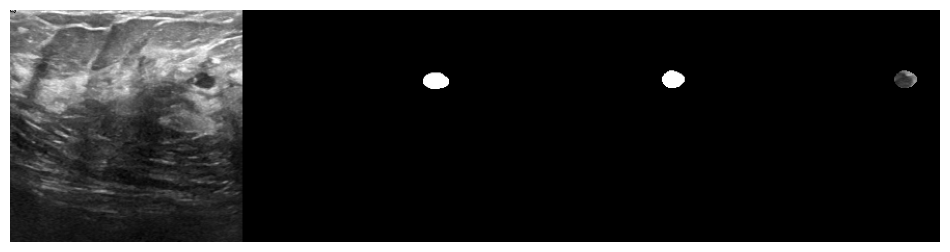

 Epoch: 51 of 100, Iter.: 33 of 33, Train Loss: 0.035821, IoU: 0.933880, Dice: 0.965225
 Epoch: 51 of 100, Iter.: 33 of 33, Valid Loss: 0.343973, IoU: 0.708479, Dice: 0.791886


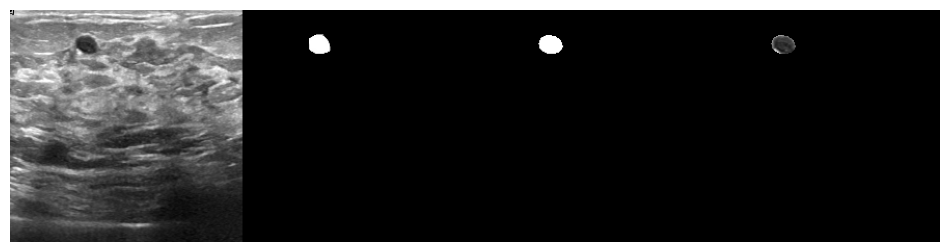

 Epoch: 52 of 100, Iter.: 33 of 33, Train Loss: 0.035472, IoU: 0.935162, Dice: 0.966055
 Epoch: 52 of 100, Iter.: 33 of 33, Valid Loss: 0.353421, IoU: 0.710747, Dice: 0.793954


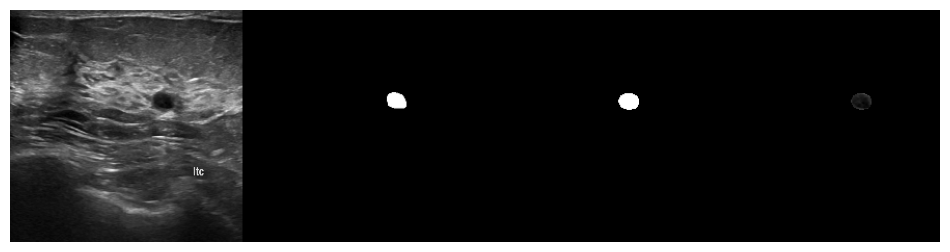

 Epoch: 53 of 100, Iter.: 33 of 33, Train Loss: 0.036895, IoU: 0.935733, Dice: 0.966364
 Epoch: 53 of 100, Iter.: 33 of 33, Valid Loss: 0.370241, IoU: 0.703409, Dice: 0.786719


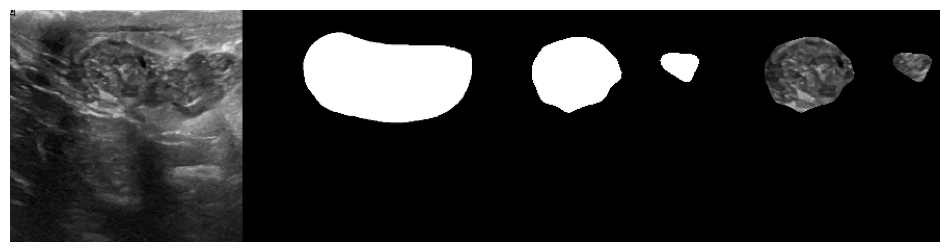

 Epoch: 54 of 100, Iter.: 33 of 33, Train Loss: 0.036760, IoU: 0.935981, Dice: 0.966495
 Epoch: 54 of 100, Iter.: 33 of 33, Valid Loss: 0.356972, IoU: 0.704311, Dice: 0.788446


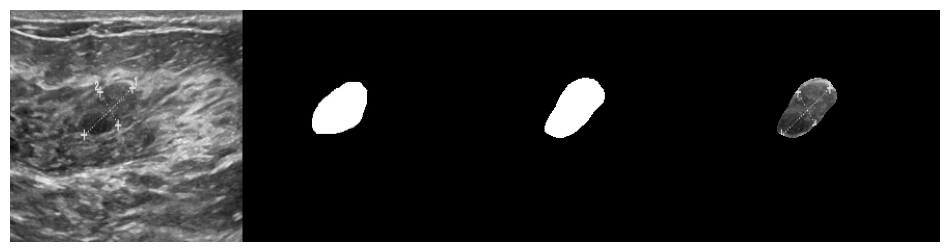

 Epoch: 55 of 100, Iter.: 33 of 33, Train Loss: 0.036356, IoU: 0.931647, Dice: 0.963822
 Epoch: 55 of 100, Iter.: 33 of 33, Valid Loss: 0.377796, IoU: 0.697411, Dice: 0.782302


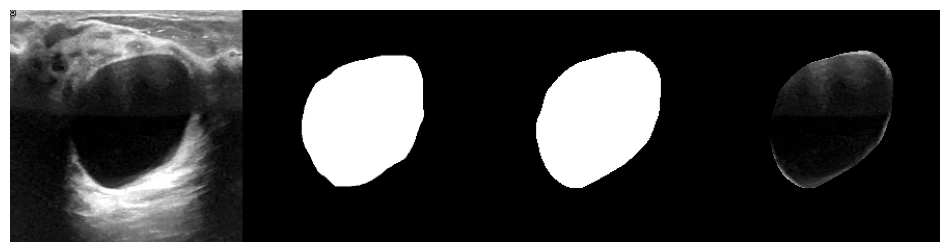


Early stopping. Target criteria has not improved for 20 epochs.

CPU times: user 4min 17s, sys: 3min 10s, total: 7min 28s
Wall time: 3min 56s


In [11]:

%%time
from ploting import plot_model_prediction

train_losses, val_losses = [], []
train_ious, val_ious = [], []
train_dices, val_dices = [], []
best_iou, best_dice, best_loss = 0, 0, np.inf
best_epoch_dice = -1
state = {}
lst_epoch_metric = []

start_time = time.time()
for epoch in range(1, epochs+1):
    running_loss, running_iou, running_dice = 0, 0, 0

    # Train
    model.train()
    for i, (imgs, masks) in enumerate(dataloader_train):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        
        optimizer.zero_grad()
        loss = criterion(prediction, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_iou += iou_pytorch_eval(prediction, masks)
        running_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, IoU:  {:.6f},  Dice:  {:.6f}".format(epoch, epochs, i, len(dataloader_train), running_loss/(i+1), running_iou/(i+1), running_dice/(i+1)), end="")
        
    # Validate
    model.eval()
    val_loss, val_iou, val_dice = 0, 0, 0
    for i, (imgs, masks) in enumerate(dataloader_val):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        loss = criterion(prediction, masks)
        val_loss += loss.item()
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, Val. Loss: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_loss/len(dataloader_train), val_loss/(i+1)), end="")
        
        val_iou += iou_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, IoU: {:.6f}, Val. IoU: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_iou/len(dataloader_train), val_iou/(i+1)), end="")

        val_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Dice: {:.6f}, Val. Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_dice/len(dataloader_train), val_dice/(i+1)), end="")
    
    
    # compute overall epoch losses
    epoch_train_loss = running_loss/len(dataloader_train)
    train_losses.append(epoch_train_loss)
    epoch_val_loss = val_loss/len(dataloader_val)
    val_losses.append(epoch_val_loss)

    # compute overall epoch iou-s
    epoch_train_iou = (running_iou/len(dataloader_train)).item()
    train_ious.append(epoch_train_iou)
    epoch_val_iou = (val_iou/len(dataloader_val)).item()
    val_ious.append(epoch_val_iou)
    
    # compute overall epoch dice
    epoch_train_dice = (running_dice/len(dataloader_train)).item()
    train_dices.append(epoch_train_dice)
    epoch_val_dice = (val_dice/len(dataloader_val)).item()
    val_dices.append(epoch_val_dice)

    print("\r Epoch: {} of {}, Iter.: {} of {}, Train Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_train_loss, epoch_train_iou, epoch_train_dice))
    print("\r Epoch: {} of {}, Iter.: {} of {}, Valid Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_val_loss, epoch_val_iou, epoch_val_dice))
    if epoch == 1:
        print('\n시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.')
    plot_model_prediction(model, DEVICE, valid_images, valid_labels)
        
    # plot
    metrics = {'loss':[train_losses, epoch_train_loss, val_losses, epoch_val_loss],
               'Iou':[train_ious, epoch_train_iou, val_ious,  epoch_val_iou],
               'Dice':[train_dices, epoch_train_dice, val_dices,  epoch_val_dice]}
    
    lst_epoch_metric.append([round(epoch_train_loss,4), round(epoch_train_iou,4), round(epoch_train_dice,4), 
                             round(epoch_val_loss,4), round(epoch_val_iou,4), round(epoch_val_dice,4)]) 

    # save if best results or break is has not improved for {patience} number of epochs
    best_iou = max(best_iou, epoch_val_iou)
    best_dice = max(best_dice, epoch_val_dice)
    best_loss = min(best_loss, epoch_val_loss)
    best_epoch_dice = epoch if best_dice == epoch_val_dice else best_epoch_dice

    # record losses
    state['train_losses'] = train_losses
    state['val_losses'] = val_losses
    
    if best_epoch_dice == epoch:
        # print('Saving..')
        state['net'] = model.state_dict()
        state['dice'] = best_dice
        state['epoch'] = epoch
            
        if not os.path.isdir('checkpoints'):
            os.mkdir('checkpoints')
        torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
    
    
    elif best_epoch_dice + patience < epoch:
        print(f"\nEarly stopping. Target criteria has not improved for {patience} epochs.\n")
        break

file_name = f'{model_name}_{data_name}'
# load once more and write all the losses down (othw can miss the last 10)
end_time = time.time() - start_time

state = torch.load(f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
state['train_losses'] = train_losses
state['val_losses'] = val_losses
torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')

df_epoch_metric = pd.DataFrame(lst_epoch_metric, columns = ['epoch_train_loss', 'epoch_val_loss', 'epoch_train_iou', 'epoch_val_iou', 'epoch_train_dice', 'epoch_val_dice'])
df_epoch_metric.to_csv(f'/project/segmentation/smcho1201/training_{model_name}/csv_{file_name}.csv', index_label = ['epoch'])

Validationset 기준 
Best_epoch:34, Best_IOU:0.7107, Best_DiceScore:0.7979


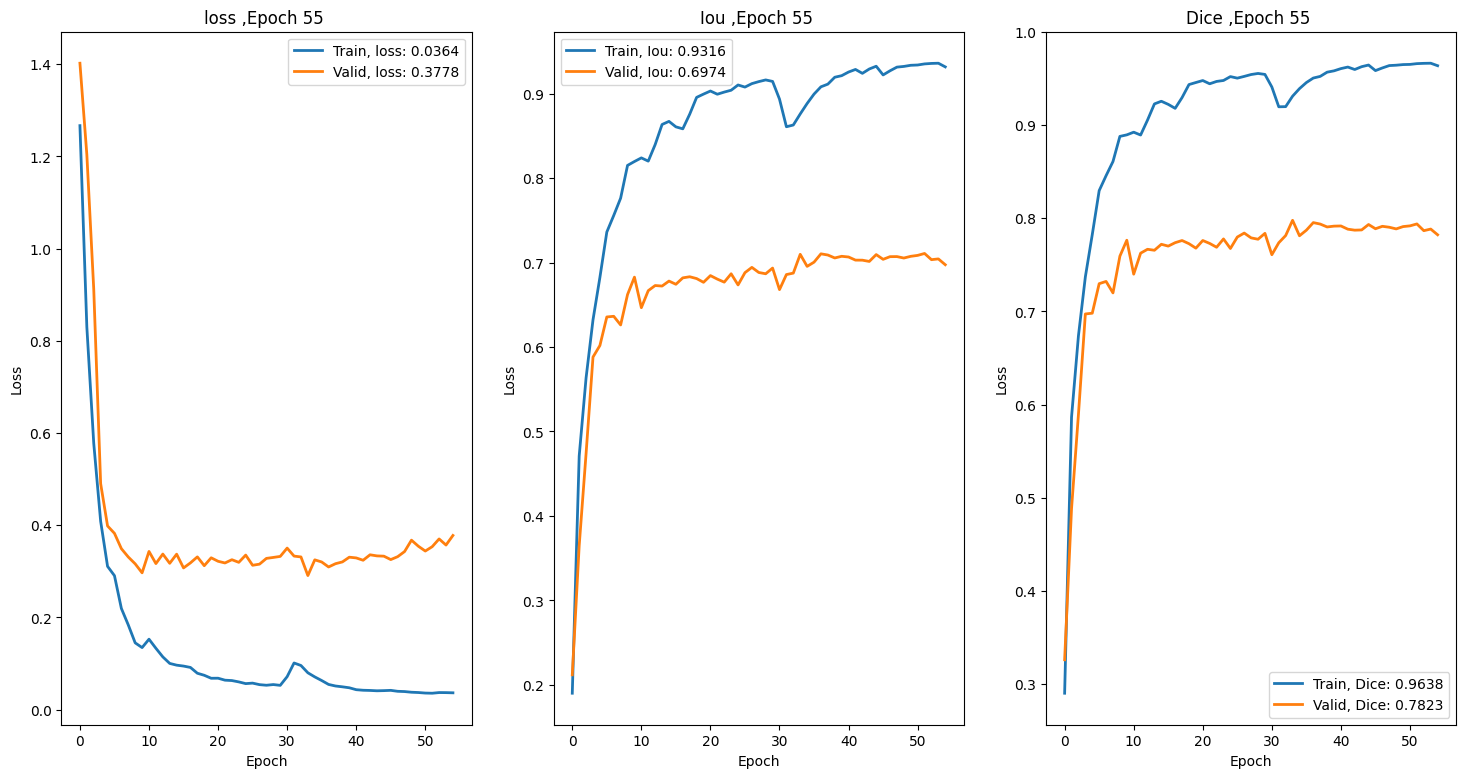

In [12]:
print(f'Validationset 기준 \nBest_epoch:{best_epoch_dice}, Best_IOU:{best_iou:.4f}, Best_DiceScore:{best_dice:.4f}')

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 9))           
for i, (metric, value) in enumerate(metrics.items()):
    axs[i].plot(np.arange(len(value[0])), value[0], label=f'Train, {metric}: {value[1]:.4f}', linewidth=2)
    axs[i].plot(np.arange(len(value[2])), value[2], label=f'Valid, {metric}: {value[3]:.4f}', linewidth=2)
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Loss')
    axs[i].set_title(f'{metric} ,Epoch {epoch} ')
    axs[i].legend(loc='best')
plt.show()